#  TP : Classification de tableaux
---

<center><img src=https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Claude_Monet_038.jpg/1920px-Claude_Monet_038.jpg width=800></center>


Dans ce TP, nous voulons classifier des tableaux de Claude Monet en utilisant l'algorithme des k-moyennes.

Le volume de données étant relativement important, je vous invite à travailler en local sur vos machines.
Commençons par télécharger les données :

<a href="https://github.com/tcanta/itc2a/blob/f6921caaecc47268c5194431353f2c41dfd1a9b2/tp/data_science/monet_jpg/monet.zip"></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob

file = '*.jpg' 
glob.glob(file)
# Using List Comprehension to read all images
#images = np.array([plt.imread(image) for image in glob.glob(file)])
images = [plt.imread(image) for image in glob.glob(file)]

digits_matrix = images

`digits_matrix` est une liste contenant tous nos tableaux de Monet.

In [2]:
images[0] # la 1ère matrice

array([[[ 45,  98, 148],
        [ 24,  77, 127],
        [ 69, 120, 173],
        ...,
        [ 44,  62,  50],
        [110, 114,  87],
        [ 77,  77,  41]],

       [[ 63, 116, 170],
        [ 25,  78, 132],
        [ 39,  90, 147],
        ...,
        [128, 142, 142],
        [169, 173, 156],
        [128, 126, 101]],

       [[ 59, 113, 173],
        [ 38,  92, 152],
        [ 41,  92, 155],
        ...,
        [103, 114, 132],
        [137, 138, 143],
        [125, 121, 118]],

       ...,

       [[124, 142, 142],
        [147, 165, 165],
        [162, 181, 179],
        ...,
        [160, 150, 123],
        [179, 170, 141],
        [ 98,  89,  58]],

       [[162, 168, 130],
        [170, 176, 142],
        [179, 183, 158],
        ...,
        [144, 134, 107],
        [157, 148, 119],
        [ 90,  81,  50]],

       [[113, 112,  55],
        [125, 123,  72],
        [103, 101,  63],
        ...,
        [119, 109,  82],
        [157, 148, 119],
        [ 64,  55,  24]]

Chacune de ces matrices est en fait une image au format .jpg contenant chaque pixel d'un tableau de Monet.  
Chaque élément de la matrice représente un pixel coloré représenté par trois valeurs entières entre 0 et 255 : le niveau de rouge, vert et bleu.
Par exemple, affichons l'image correspondant à la matrice 160 :

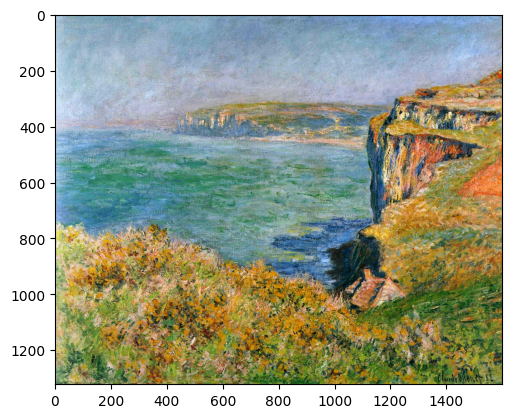

In [3]:
plt.imshow(digits_matrix[161])
plt.show()

## Redimensionner les images



Nous avons tout d'abord besoin de redimensionner nos images à la même taille.
Une manière simple de s'y prendre consiste à couper nos images, de sorte que la taille finale de chacune corresponde à la hauteur minimale parmi les images du jeu de données par la largeur minimale trouvée.

**Question** : Définir une fonction `crop_to_min` standardisant la taille des images.

256 256


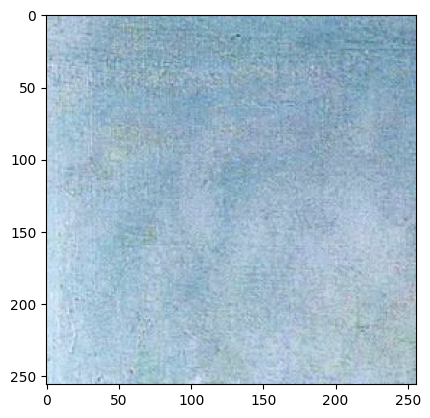

In [4]:
def crop_to_min(images):
    #recherche de minimums
    h_min = len(images[0])
    l_min = len(images[0][0])
    for image in images:
        if h_min > len(image):
            h_min = len(image)
        if l_min > len(image[0]):
            l_min = len(image[0])
    print(h_min, l_min)
    #Découpage des images
    l=[]
    for image in images:
        l.append(image[:h_min,:l_min])
    return l

digits_matrix = crop_to_min(images)
plt.imshow(digits_matrix[161])
plt.show() 

Pour appliquer l'algorithme des $k$-moyennes, il faut que les données soient des vecteurs. On transforme donc une matrice en vecteur en concaténant les lignes de la matrice :  
$$
\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{pmatrix}
\longrightarrow
\begin{pmatrix}
1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9
\end{pmatrix}
$$

**Question** : Écrire une fonction `to_vector(m)` qui prend en argument une matrice `m` et renvoie le vecteur correspondant, sous forme de liste.

In [5]:
def to_vector(m):
    v = []
    for i in range(0,len(m)):
        for j in range(0,len(m[0])):
            v.append(m[i][j])
    return v

In [6]:
print(len(to_vector(digits_matrix[0])))
assert len(to_vector(digits_matrix[0])) == len(digits_matrix[0])*len(digits_matrix[0][0]) # les images 256*256*3 sont transformées en vecteur 65536*3

65536


**Question** : Écrire une fonction `to_matrix(v)` qui prend en argument un vecteur `v` et renvoie la matrice correspondante, sous forme de liste de listes. On suppose que la matrice est carrée.

In [7]:
def to_matrix(vector):
    mat = [[[0,0,0] for i in range(0, 256)] for j in range(0, 256)]
    for i in range(0, 256):
        for j in range(0, 256):
            mat[i][j] = vector[i*256+j]
    return mat

In [8]:
assert (to_matrix(to_vector(digits_matrix[0])) == digits_matrix[0]).all() 
# to_matrix et to_vector sont inverses l'une de l'autre

**Question** : Définir une liste `X` contenant les vecteurs correspondant aux images dans `digits_matrix`. Cette variable `X` sera utilisée dans toute la suite.

In [9]:
X = []
for i in range(0, len(digits_matrix)):
    X.append(to_vector(digits_matrix[i]))

## Algorithmes des $k$-moyennes

**Question** : Écrire une fonction `d(u, v)` qui prend en argument deux images `u` et `v` et renvoie la distance euclidienne entre ces deux vecteurs. On considerera ici que la distance entre deux images est la somme des distances entre les composantes rouges, vertes et bleues de ces images.

In [10]:
def d(u, v):
    r = np.int64(0)
    g = np.int64(0)
    b = np.int64(0)
    for i in range(0, len(u)):
        r += (np.int64(u[i][0]) - np.int64(v[i][0]))**2
        g += (np.int64(u[i][1]) - np.int64(v[i][1]))**2
        b += (np.int64(u[i][2]) - np.int64(v[i][2]))**2
    return r**.5 + g**.5 + b**.5

In [11]:
d(X[0], X[1])

np.float64(68997.31031030507)

Comme dans le cours, nous utilisons une liste `centres` pour stocker les centres des classes. `centres[i]` est le centre de la classe $i$.

**Question** : Écrire une fonction `centres_aléatoires(X, k)` qui prend en argument une liste de vecteurs `X` et un entier `k` et renvoie une liste de `k` vecteurs aléatoires choisis dans `X`.  
On utilisera `random.sample` dont [on pourra consulter la documentation ici](https://docs.python.org/3/library/random.html). On pourra préalablement utiliser `random.seed(0)` pour avoir les mêmes résultats que le corrigé du TP.

In [12]:
import random

random.seed(0) # pour avoir toujours les mêmes résultats
def centres_aléatoires(X, k):
    return random.sample(X, k)

In [13]:
centres = centres_aléatoires(X, 5)
assert len(centres) == 5

**Question** : Écrire une fonction `plus_proche(x, centres)` qui prend en argument un vecteur `x` et une liste de vecteurs `centres` et renvoie l'indice du centre le plus proche de `x`.

In [14]:
def plus_proche(x, centres):
    return min(range(len(centres)), key=lambda i: d(x, centres[i]))

In [15]:
plus_proche(X[1], centres)

2

Contrairement à ce qui a été fait dans le cours, on utilise dans la suite une liste `classes` telle que `classes[i]` est le numéro de classe de `X[i]` (dans le cours, `classes[i]` était la liste des vecteurs de la classe $i$).

**Question** : Écrire une fonction `calculer_classes(X, centres)` qui renvoie la liste `classes` correspondant à `X` et à `centres`. Il faut donc que `classes[i]` soit l'indice du centre (dans `centres`) le plus proche de `X[i]`.

In [16]:
def calculer_classes(X, centres):
    classes = []
    for x in X:
        classes.append(plus_proche(x, centres))
    return classes

In [17]:
classes = calculer_classes(X[:20], centres_aléatoires(X[:20], 5))
#assert len(classes) == len(X) and max(classes) < 10 and min(classes) >= 0

In [18]:
print(classes)

[2, 4, 4, 0, 0, 0, 0, 0, 0, 2, 0, 4, 1, 0, 0, 0, 2, 0, 0, 3]


**Question** : Écrire une fonction `centre(X, classes, i)` qui renvoie le centre de la classe $i$.

In [19]:
def centre(X, classes, i):
    p = len(X[0])
    c = [[0]*3 for _ in range(p)]
    n = 0
    for j in range(len(X)):
        if classes[j] == i:
            n += 1
            for k in range(p):
                for l in range(3):
                    c[k][l] += np.float64(X[j][k][l])
    if n==0:
        return c
    for k in range(p):
        for l in range(3):
            c[k][l] = np.uint8(c[k][l]/n)
    return c

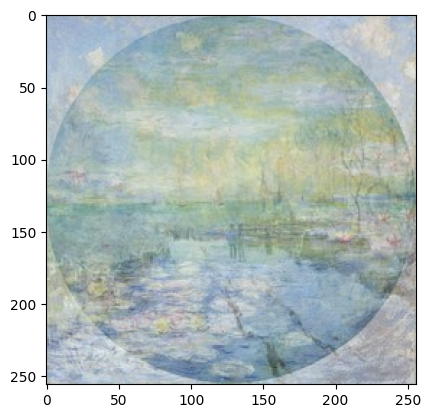

In [20]:
plt.imshow(to_matrix(centre(X[:20], classes, 2)))
plt.show() 

**Question** : Écrire une fonction `calculer_centres(X, classes, k)` qui renvoie la liste `centres` correspondant à `X` et à `classes`.

In [21]:
def calculer_centres(X, classes, k):
    centres = []
    for i in range(0, k):
        centres.append(centre(X, classes, i))
    return centres

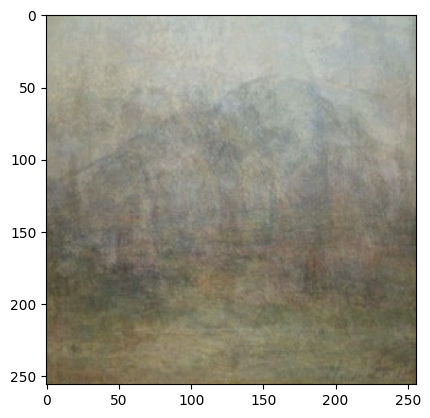

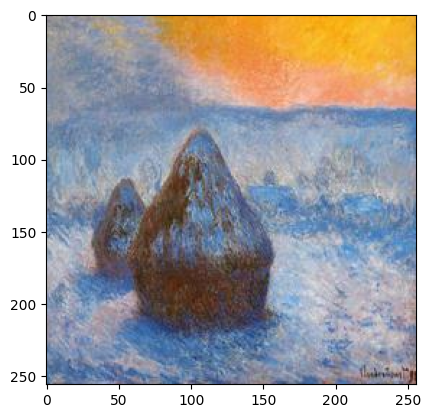

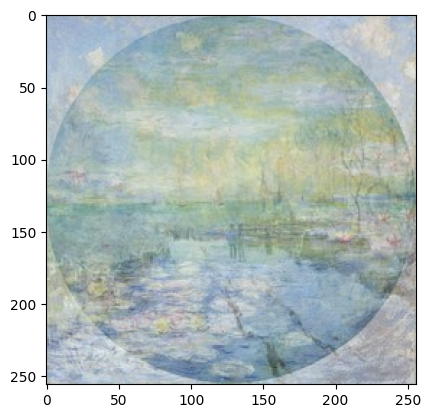

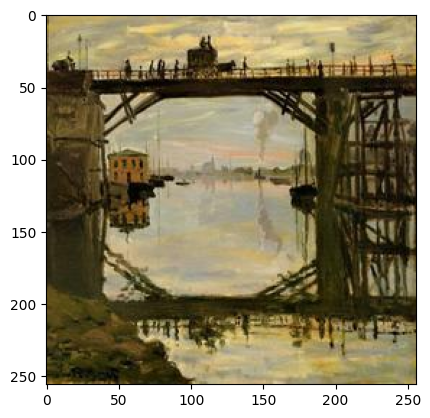

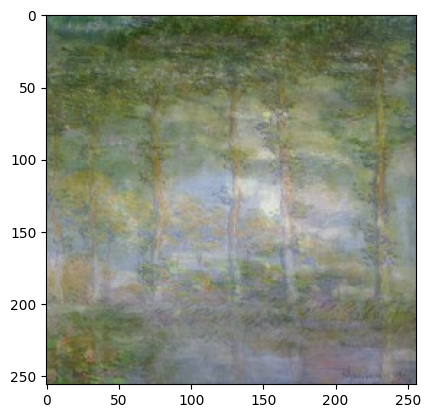

In [22]:
#classes = calculer_classes(X[:20], centres_aléatoires(X, 5))
centres = calculer_centres(X[:20], classes, 5)

plt.imshow(to_matrix(centres[0]))
plt.show()
plt.imshow(to_matrix(centres[1]))
plt.show()
plt.imshow(to_matrix(centres[2]))
plt.show()
plt.imshow(to_matrix(centres[3]))
plt.show()
plt.imshow(to_matrix(centres[4]))
plt.show()

**Question** : Écrire une fonction `kmeans(X, centres, k)` qui, à partir de centres initiaux donnés en argument, applique l'algorithme des $k$-moyennes et renvoie un couple correspondant à la liste `(centres, classes)` obtenue à la fin de l'algorithme.

In [23]:
def kmeans(X, centres, k):
    classes = calculer_classes(X, centres)
    centres = calculer_centres(X, classes, k)
    if classes != calculer_classes(X, centres):
        return kmeans(X, centres, k)
    return centres, classes

In [24]:
k = 5
centres, classes = kmeans(X[:20], centres_aléatoires(X, k), k) # ceci prend quelques secondes
fig, axes = plt.subplots(5, figsize=(20, 20))
for ax, center in zip(axes.ravel(), centres):
    ax.matshow(np.array(to_matrix(center)))
    ax.axis('off')
plt.show()

KeyboardInterrupt: 

## Calcul de l'inertie

Dans cette partie, on réutilise les listes `centres` et `classes` obtenues précédemment par un appel à `kmeans`.

**Question** : Écrire une fonction `inertie(X, centres, classes)` qui renvoie l'inertie de la partition définie par `classes`. On rappelle que l'inertie d'une partition est la somme des distances au carré des points à leur centre de classe.

In [181]:
def inertie(X, centres, classes):
    s = 0
    for i in range(len(X)):
        s += d(X[i], centres[classes[i]])**2
    return s

In [182]:
inertie(X[:20], centres, classes)

22258872150.370857

**Question** : Réécrire la fonction `kmeans` précédente de façon à ce qu'elle renvoie aussi la liste des inerties obtenues à chaque itération de l'algorithme. Utiliser le code ci-dessous pour afficher aussi l'évolution de l'inertie au cours des itérations. Commenter.

In [183]:
from copy import deepcopy
def kmeans(X, centres, k):
    inerties = []
    centres2 = deepcopy(centres)
    centres2[0][0]=257
    while not np.array_equal(centres ,centres2):
        centres2 = deepcopy(centres)
        classes = calculer_classes(X, centres2)
        centres = calculer_centres(X, classes, k)
        inerties.append(inertie(X, centres, classes))
    return centres, classes, inerties

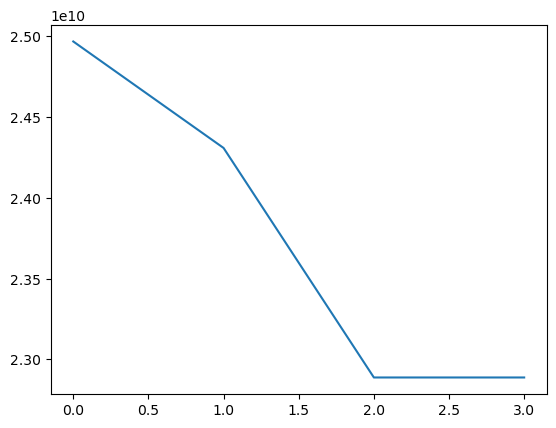

In [191]:
k=5
centres, classes, inerties = kmeans(X[:20], centres_aléatoires(X, k), k) # ceci prend quelques minutes
plt.plot(inerties)
plt.show()

## Choix de la valeur de k

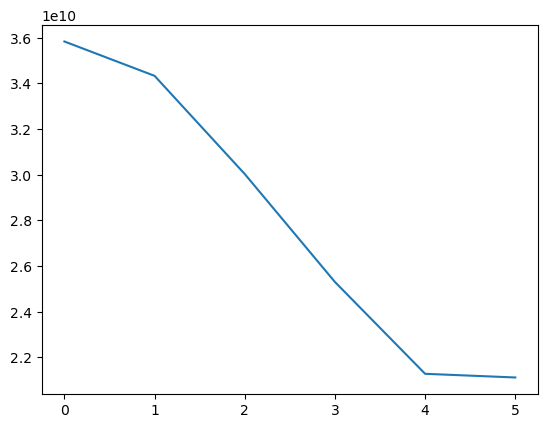

In [192]:
k=5
inerties=[]
for k in range(2,8):
    centres, classes, i = kmeans(X[:20], centres_aléatoires(X, k), k) # ceci prend quelques minutes
    inerties.append(i[-1])
    print(k)

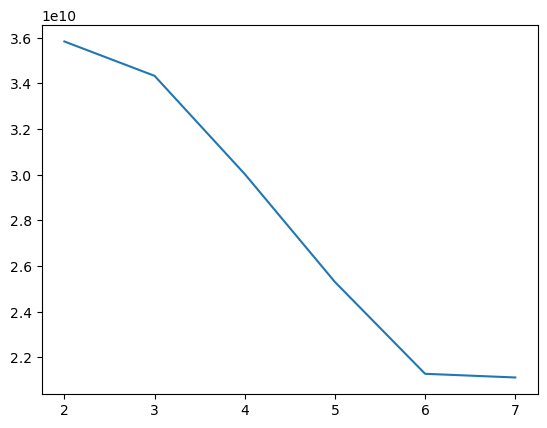

In [199]:
plt.plot(range(2,8),inerties[:6])

**Question** : Quelle valeur de k à l'air pertinente pour notre echantillon de tableaux ?

## Amélioration de la fonction crop

Précédement, nous avions utilisé une fonction qui découpait les images trop grandes en ne gardant que les pixels correspondant au rectangle en haut à gauche de l'image.

**Question** : Proposer une amélioration de la fonction crop qui prenne mieux en compte l'image dans sa globalité.